# Parte 2: CNN con imágenes con Bilateral Filter

In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import numpy as np
import seaborn as sns

saveImages = True

In [6]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]

# Resized image directories
filtered_covid_folder = 'dataset/filtered_images/COVID'
filtered_lung_opacity_folder = 'dataset/filtered_images/Lung_Opacity'
filtered_normal_folder = 'dataset/filtered_images/Normal'
filtered_viral_pneumonia_folder = 'dataset/filtered_images/Viral_Pneumonia'
filtered_folders = [filtered_covid_folder, filtered_lung_opacity_folder, filtered_normal_folder, filtered_viral_pneumonia_folder]


In [7]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        
# Convert to string time
def get_str_time(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    if hours == 0:
        if minutes == 0:
            return f'{seconds}s'
        return f'{minutes}m {seconds}s'
    return f'{hours}h {minutes}m {seconds}s'

# Calculate the metrics using sklearn.metrics
class_names = ['Covid', 'Lung Opacity', 'Normal', 'Pneumonia']
colors = ['blue', 'red', 'green', 'orange']
def get_metrics(model, X_test, y_test, time):

    # Get the model predictions
    y_pred  = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    # Confusion
    confusion(y_test, y_pred_classes)
        
    # Get metrics
    report = classification_report(y_test, y_pred_classes, target_names=class_names)
    print(report)
    
    # Show ROC
    ROC_auc(y_test, y_pred)

    
    # Show time
    print(f'Processing time: {time}\n')
    return report

# Show ROC chart for each class
def ROC_auc(y_test, y_pred):
    # Compute the fpr (false positive rate), tpr (true positive rate), and thresholds for each class
    n_classes = y_test.max() + 1
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the ROC curves for each class
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='(AUC = %0.2f) %s' % (roc_auc[i], class_names[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def confusion(y_test, y_pred_classes):
    # Create a heatmap of the confusion matrix
    error = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(7, 5))
    sns.heatmap(error, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# 1. DATA ANALYSIS

Image dimensions: (299, 299)


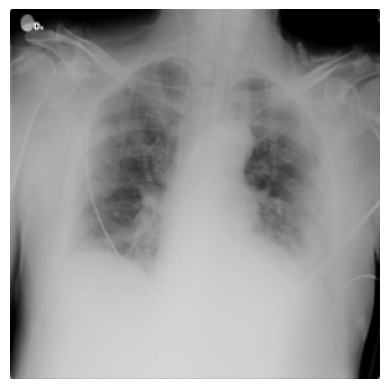

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [8]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 2. Aplicación de filtro bilateral

In [9]:
# Create directories if they don't exist
create_directories(filtered_folders)

# Function to apply bilateral filter to images and save them in the new directories
def bilateral_filter_and_save_images(image_folder, filtered_folder, samples):
    image_files = os.listdir(image_folder)
    image_files = image_files[:samples]  # Select the specified number of samples
    for file_name in image_files:
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        filtered_img = cv2.bilateralFilter(img, 9, 75, 75)  # Apply bilateral filter to the image
        new_file_name = os.path.splitext(file_name)[0] + '_filtered.png'  # New file name
        cv2.imwrite(os.path.join(filtered_folder, new_file_name), filtered_img)

if saveImages:
    # Apply bilateral filter to images and save them
    num_samples = [3616, 3700, 3700, 1345]
    [bilateral_filter_and_save_images(clean_folder, filtered_folder, samples) for clean_folder, filtered_folder, samples in zip(clean_folders, filtered_folders, num_samples)]
    print("FILTERED IMAGES SAVED IN THE NEW DIRECTORIES.")


FILTERED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (299, 299)


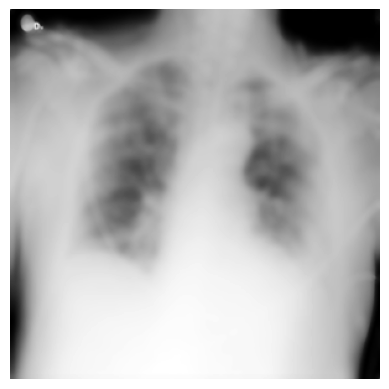

Number of images per class


In [10]:
# Show information
image = cv2.imread(filtered_covid_folder+'/COVID-1_filtered.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=filtered_folders, img=image)
# df

# 4. TRAINING

Load the data of 'X' and 'y'

In [11]:
covid_data = load_data(clean_covid_folder, 0)
lung_opacity_data = load_data(clean_lung_opacity_folder, 1)
normal_data = load_data(clean_normal_folder, 2)
viral_pneumonia_data = load_data(clean_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [12]:
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocess the data
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Check the dimensions of the training and test sets
pd.DataFrame({
    'Variable': ['X train', 'y train',  'X test', 'y test'],
    'Dimensions': [X_train.shape, y_train_categorical.shape, X_test.shape, y_test_categorical.shape],
}).style.hide().set_properties(**{'text-align': 'left'})


Variable,Dimensions
X train,"(14815, 299, 299)"
y train,"(14815, 4)"
X test,"(6350, 299, 299)"
y test,"(6350, 4)"


# CNN

## Arquitectura 1

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()
model.fit(X_train, y_train_categorical, batch_size=130, epochs=5, verbose=2)
train_time = get_str_time(time.time() - start)

Epoch 1/5
114/114 - 314s - loss: 691.5789 - accuracy: 0.5736 - 314s/epoch - 3s/step
Epoch 2/5
114/114 - 1249s - loss: 9.6575 - accuracy: 0.7484 - 1249s/epoch - 11s/step
Epoch 3/5
114/114 - 1123s - loss: 2.4293 - accuracy: 0.8270 - 1123s/epoch - 10s/step
Epoch 4/5
114/114 - 292s - loss: 1.9547 - accuracy: 0.8433 - 292s/epoch - 3s/step
Epoch 5/5
114/114 - 313s - loss: 0.7528 - accuracy: 0.9062 - 313s/epoch - 3s/step


199/199 [==============================] - 20s 97ms/step
              precision    recall  f1-score   support

       Covid       0.84      0.76      0.80      1085
Lung Opacity       0.72      0.76      0.74      1804
      Normal       0.82      0.84      0.83      3058
   Pneumonia       0.97      0.82      0.89       403

    accuracy                           0.80      6350
   macro avg       0.84      0.79      0.81      6350
weighted avg       0.81      0.80      0.80      6350



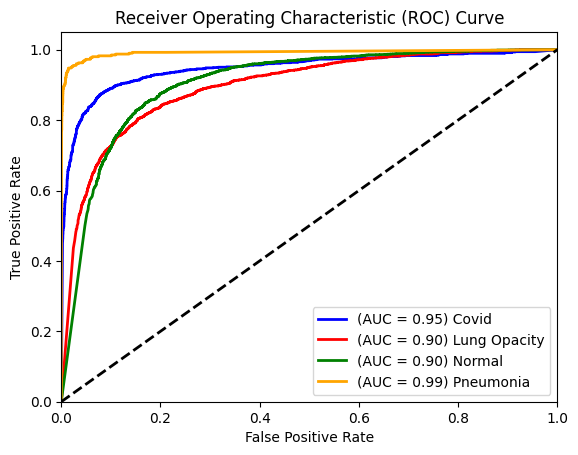

Processing time: 54m 59s



In [14]:
# Evaluate model    
results1 = get_metrics(model=model, X_test=X_test, y_test=y_test, time=train_time)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 700928)            0         
                                                                 
 dense (Dense)               (None, 128)               89718912  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                        

# Comparación CNN con imagenes crudas vs CNN con imagenes filtradas:

## CNN con imagenes crudas:

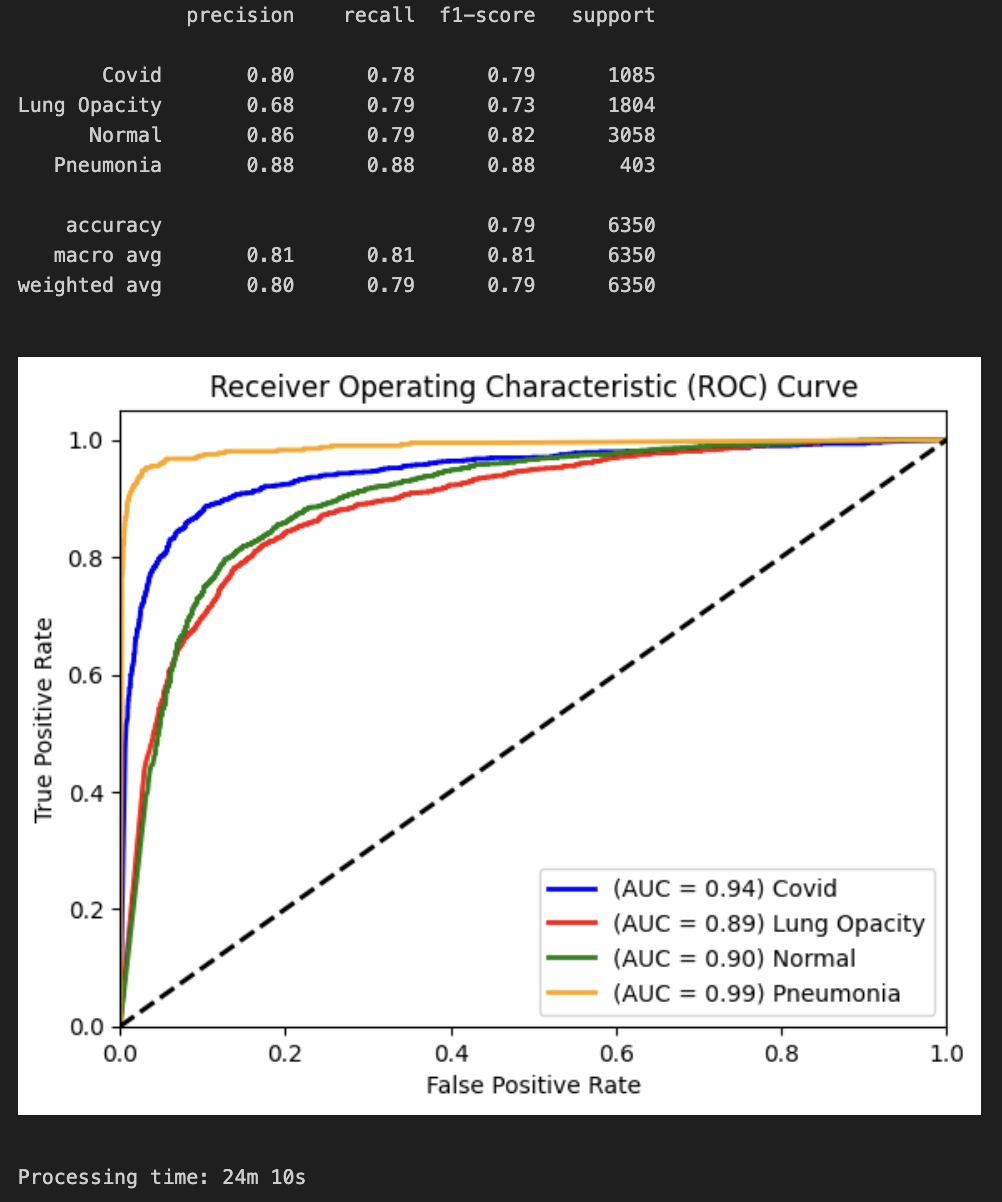

In [17]:
from PIL import Image
from IPython.display import display

# Ruta de la imagen
ruta_imagen = 'cnn_crudas.png'  # Reemplaza con la ruta de tu imagen

# Carga de la imagen
imagen = Image.open(ruta_imagen)

# Mostrar la imagen en la consola
display(imagen)


## CNN con imagenes filtradas:

199/199 [==============================] - 16s 82ms/step
              precision    recall  f1-score   support

       Covid       0.84      0.76      0.80      1085
Lung Opacity       0.72      0.76      0.74      1804
      Normal       0.82      0.84      0.83      3058
   Pneumonia       0.97      0.82      0.89       403

    accuracy                           0.80      6350
   macro avg       0.84      0.79      0.81      6350
weighted avg       0.81      0.80      0.80      6350



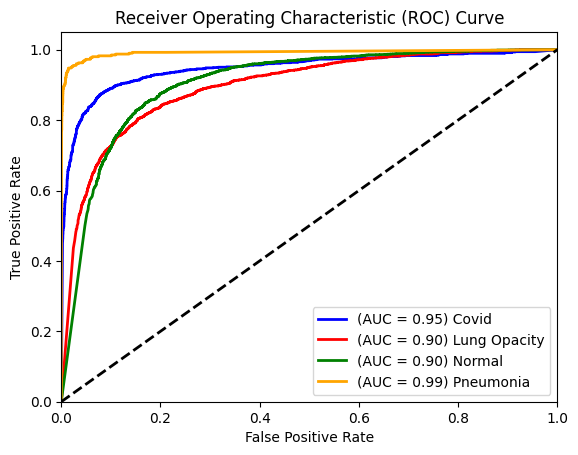

Processing time: 54m 59s



In [15]:
# Evaluate model    
results1 = get_metrics(model=model, X_test=X_test, y_test=y_test, time=train_time)